## Scale Invariant Feature Transform (SIFT)

### Find the keypoints

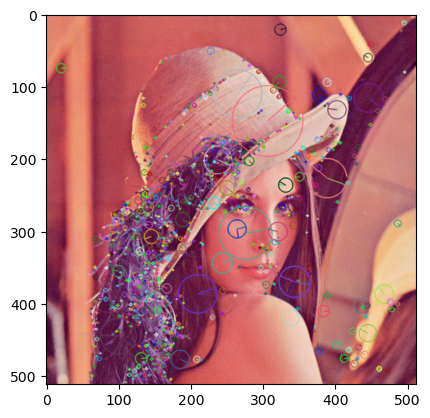

In [6]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

img = cv2.imread("../lenna.png")
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT_create()
keypoints, descriptors = sift.detectAndCompute(img_gray, None)

img_sift = cv2.drawKeypoints(image=img, outImage=img, keypoints=keypoints,
                        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.imshow(cv2.cvtColor(img_sift, cv2.COLOR_BGR2RGB))
plt.show()

### Find the keypoints and match them

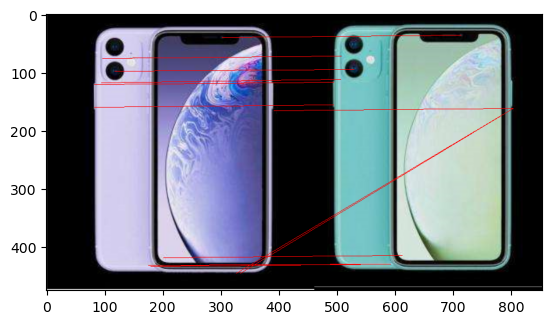

In [11]:
def drawMatchesKnn_cv2(img1_gray, keypoints1, img2_gray, keypoints2, matches):
    h1, w1= img1_gray.shape[:2]
    h2, w2= img2_gray.shape[:2]

    out_img = np.zeros((max(h1, h2), w1+w2, 3), np.uint8)
    out_img[:h1, :w1] = img1_gray
    out_img[:h2, w1:w1+w2] = img2_gray

    p1 = [kpp.queryIdx for kpp in matches]
    p2 = [kpp.trainIdx for kpp in matches]

    post1 = np.int32([keypoints1[pp].pt for pp in p1])
    post2 = np.int32([keypoints2[pp].pt for pp in p2]) + (w1, 0)

    for (x1, y1), (x2, y2) in zip(post1, post2):
        cv2.line(out_img, (x1, y1), (x2, y2), (0, 0, 255))
    
    plt.imshow(cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB))
    plt.show()

img1 = cv2.imread("./iphone1.png")
img2 = cv2.imread("./iphone2.png")

sift = cv2.SIFT_create()

kp1, desc1 = sift.detectAndCompute(cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY), None)
kp2, desc2 = sift.detectAndCompute(cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY), None)

bf = cv2.BFMatcher()
matches = bf.knnMatch(desc1, desc2, k=2)

good_matches = []
for m, n in matches:
    if m.distance < 0.50 * n.distance:
        good_matches.append(m)

drawMatchesKnn_cv2(img1, kp1, img2, kp2, good_matches[:20])

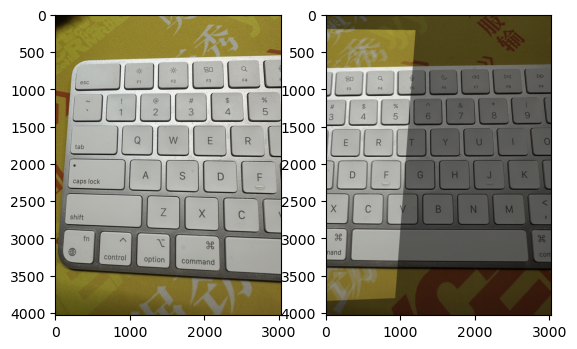

In [14]:
# image stitching
def img_stitching(img1, keypoints1, img2, keypoints2, matches):
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    h, w, d = img1.shape
    
    img1_warped = cv2.warpPerspective(img1, M, (w, h))

    result = cv2.addWeighted(img1_warped, 0.5, img2, 0.5, 0)
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.show()


img1 = cv2.imread("./keyboard1.png")
img2 = cv2.imread("./keyboard2.png")

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.show()

sift = cv2.SIFT_create()
kp1, desc1 = sift.detectAndCompute(cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY), None)
kp2, desc2 = sift.detectAndCompute(cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY), None)

bf = cv2.BFMatcher()
# FLANN_INDEX_KDTREE = 1
# index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
# search_params = dict(checks=50)

# flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = bf.knnMatch(desc1, desc2, k=2)

good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)
    
img_stitching(img1, kp1, img2, kp2, good_matches)

